## [4주차_기다연] 개선된 word2vec
1. 데이터 크롤링
2. 데이터셋 EDA, 전처리, Tokenization
3. 문장, 단어 토큰화, 정수 인코딩
4. SGNS 데이터셋 구성
5. 개선된 word2vec 모델 생성 (네거티브 샘플링 추가)

#### **과제 내용**
참고사이트: [네거티브 샘플링을 이용한 Word2vec](https://wikidocs.net/69141)<br>
3주차 과제였던 'word2vec' 모델의 속도 개선을 이루는 2가지 방법:
1. Embedding 계층 추가<br>
: 단어 임베딩(분산 표현)을 저장하는 계층
2. Negative Sampling 활용<br>
: 긍정적인 예에 대해서만 학습하는 것이 아닌, 부정적인 예에 대해서도 학습할 수 있어야 한다. 하지만 모든 부정적 예를 대상으로 이진 분류를 학습하기에는 어휘량이 너무 많다. 이를 위해 근사적인 해법으로 **적은 수의 부정적 예를 샘플링해 사용**하는 네거티브 샘플링을 차용한다.

In [ ]:
#Initial Setting (font, display)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'") #화질 보정

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds #SVD
from string import punctuation

#NLP Preprocessing package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
print('Ready')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Ready


#### 1) 2020 도쿄올림픽 관련 기사 데이터 크롤링
- 출처: [The Korea Herald](http://www.koreaherald.com/list.php?ct=020500000000&np=1&mp=1)


In [ ]:
!pip3 install selenium

In [ ]:
#Packages for data crawling
from selenium import webdriver
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.keys import Keys
import time
import sys
import requests

#colab에서 selenium을 사용하기 위해서는 지정해줘야 하는 부분
!apt-get update
!apt install chromium-chromedriver

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument("--single-process")
options.add_argument("--window-size=1920,1080")
options.add_argument("--disable-dev-shm-usage")
options.add_argument("disable-gpu")

options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36")
driver = webdriver.Chrome('chromedriver', options=options)

delay_time = 0.5
driver.implicitly_wait(delay_time)

driver.get(url)

In [ ]:
#Data Crawling (도쿄 올림픽 관련 뉴스기사 데이터)
#게시글 데이터 담을 데이터프레임 생성
olympic_news = pd.DataFrame(columns = ['post'])

#게시글 105개 가져오기
#한 페이지당 게시글 15개가 있지만 도쿄 올림픽 관련 기사는 7페이지까지 있으므로 7페이지까지 크롤링
for k in range(1, 8): 
  for i in range(1, 16):
    url = "http://www.koreaherald.com/list.php?ct=020500000000&np=%d&mp=1" % k #페이지가 바뀌면서 np=(페이지 넘버)로 변환됨
    driver.get(url)
    info = driver.find_elements_by_xpath("/html/body/div[3]/div/div[1]/ul[1]/li[%d]/a" % i)
    for n in info:
      n.click() #각 게시글로 접속
      olympic_post = []
      try:
        post = driver.find_element_by_xpath("/html/body/div[3]/div/div[1]/div[1]/div[3]/div[2]")
        post = post.text
        olympic_post.append(post)

        new_data = {'post': post}
        olympic_news = olympic_news.append(new_data, ignore_index=True)
        print('pass')
      except:
        print('error')

In [ ]:
#상위 post 2개 확인
pd.set_option('display.max_colwidth', -1) #truncated되지 않고 post 모두 보여주기
olympic_news[:2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,post
0,"TOKYO -- By reaching the semifinals of the men's table tennis team event at the Tokyo Olympics on Monday, Korea has set up a likely showdown against China, the singular force in international ping pong.\n\n Korea defeated Brazil 3-0 in the quarterfinals earlier in the day at Tokyo Metropolitan Gymnasium. Though China still had to beat France later in the evening to reach the semifinals, no South Korean player expected to see anyone else but China.\n\n Lee Sang-su said it matters not whom his team will play because the goal all along has been to win the ultimate prize.\n\n ""We've come to Tokyo to win the gold. And I think there is absolutely no one that we can't beat,"" Lee said. ""The same goes for China. If we can execute what we've prepared, then we can beat China.""\n\n China has collected 28 out of 33 gold medals in table tennis so far. In international team matches, South Korea has beaten China just once in 26 meetings. That lone victory came in 1995.\n\n Don't tell that to South Korean players in Tokyo now. Jeoung Young-sik said the Chinese players are human, just like everyone else.\n\n ""I believe we can have an upset win if we prepare for the match the best we can,"" said Jeoung, who lost to world No. 1 from China, Fan Zhendong, in the quarterfinals of the individual event. ""The team event is all about three players coming together.""\n\n Against Brazil, Lee and Jeoung won their opening doubles match 3-0 (11-6, 11-2, 12-10) over Vitor Ishiy and Gustavo Tsuboi. Then Jang Woo-jin stepped up for the first singles match and shut down Hugo Calderano 3-0 (11-6, 11-8, 12-10). Jang had lost to Calderano in the round of 16 in the individual competition, and got his revenge Monday.\n\n ""I was still getting acclimated to the Olympic competition back then, and I was rushing every shot,"" Jang said of his earlier loss.\n\n""Today, I was more relaxed. Even before the match, I had a feeling that I was going to win.""\n\n As for the prospect of facing China, Jang said, ""I think the pressure will be on the Chinese players as the chased. We're going to be relaxed."""
1,"SAITAMA -- South Korean players Im Sung-jae and Kim Si-woo both ended well out of medal contention in the Tokyo Olympic men's golf tournament on Sunday.\n\nIm shot a bogey-free round of three-under 68 on Sunday at Kasumigaseki Country Club in Saitama, north of Tokyo, and finished at 10-under for the four-round competition. He finished tied for 22nd with four others.\n\nXander Schauffele of the United States won the gold medal at 18-under 266. Rory Sabbatini of Slovakia posted a blistering round of 10-under 61 to soar to the silver medal at 17-under.\n\nThe other South Korean in the field of 60 players, Kim Si-woo, carded a bogey-free 67 to finish at eight-under for the Olympics. He ended in a three-way tie for 32nd.\n\nIm entered Sunday with an outside shot at a medal, as he sat five shots back of a group of players tied for third place. Im shot an eight-under 63 on Saturday, the best score in the field.\n\nBut Im missed too many short putts in the final round to make any noise.\n\n""I am so disappointed that things didn't go the way I wanted them to. I've been trying all season to prepare for the Olympics,"" Im said. ""I'll try to use my experience from here to win a medal at the next Olympics.""\n\nIm made three birdies in his only bogey-free round of the tournament. The score could have been much lower if not for missed putts.\n\n""I wanted to stay focused on every shot, trying to move up the leaderboard even if I wasn't going to win a medal,"" Im said. ""But my putter deserted me down the stretch. I missed about three putts within three meters of the hole.""\n\nThe one that really stung Im was the one-meter birdie attempt at the par-5 14th.\n\n""If I made that one, things would have turned out differently,"" said Im, the 2018-2019 PGA Tour Rookie of the Year.\n\nThere's no time to sulk for Im, who is scheduled to fly back to the United States on Monday 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
olympic_news.to_csv('drive/My Drive/21 SUM/KUBIG/방학 NLP 세션/tokyo_olympic_news.csv')

In [ ]:
#길이 확인
print('총 샘플 수 :',len(olympic_news))

총 샘플 수 : 73


#### 2) 데이터 전처리
- 영어만 남겨두기 (특수문자, 문자기호 제거)
- 길이가 2 이하인 단어는 제거 (길이가 짧은 단어)
- 전체 단어에 대해 소문자 변환
- 불용어 제거
- 문장 토큰화, 단어 토큰화, 정수 인코딩

In [ ]:
olympic_news = pd.read_csv('drive/My Drive/21 SUM/KUBIG/방학 NLP 세션/tokyo_olympic_news.csv')

In [ ]:
#NLP packages
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#check NULL value
#NULl값이 없더라도 빈 값 유무 확인하기 위해 모든 빈 값을 NULL로 변환하고, 다시 NULL값이 있는지 확인
olympic_news.replace("", float("NaN"), inplace=True)
print(olympic_news.isnull().values.any())

False


In [ ]:
olympic_news.dropna(inplace=True)

In [ ]:
#문장 토큰화
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
text = []

for sent in olympic_news['post']:
  temp = sent_tokenize(sent)
  text.append(temp)
  
print(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[["TOKYO -- By reaching the semifinals of the men's table tennis team event at the Tokyo Olympics on Monday, Korea has set up a likely showdown against China, the singular force in international ping pong.", 'Korea defeated Brazil 3-0 in the quarterfinals earlier in the day at Tokyo Metropolitan Gymnasium.', 'Though China still had to beat France later in the evening to reach the semifinals, no South Korean player expected to see anyone else but China.', 'Lee Sang-su said it matters not whom his team will play because the goal all along has been to win the ultimate prize.', '"We\'ve come to Tokyo to win the gold.', 'And I think there is absolutely no one that we can\'t beat," Lee said.', '"The same goes for China.', 'If we can execute what we\'ve prepared, then we can beat China."', 'China has collected 28 out of 33 gold medals in table tennis so far.', 'In international team 

#### 3) 문장, 단어 토큰화, 정수 인코딩
<b>정수 인코딩 하는 방법</b><br>
참고사이트: https://godcode.tistory.com/7

- word_to_index 집합 만들어서 각각 변경해주기
- Counter() 메서드 사용
- NLTK의 FreqDist() 빈도수 계산 도구 사용

In [ ]:
#단어 토큰화
vocab = {}
sentences = []
stop_words = set(stopwords.words('english'))

for i in text:
  for k in range(0, len(i)):
    sentence = word_tokenize(i[k]) #단어 토큰화
    result = []

    for word in sentence:
      word = word.lower() #소문자화
      word = word.encode('ascii', 'ignore').decode() #accent 된 문자가 들어가는 경우 제외 (영어문자만 취급)
      if word not in stop_words: #불용어 제거
        if len(word) > 2: #단어 길이 2 이하인 경우 단어 제거
          result.append(word)
          
          if word not in vocab:
            vocab[word] = 0
          vocab[word] += 1
    sentences.append(result)

print(sentences)
print(vocab)

[['tokyo', 'reaching', 'semifinals', 'men', 'table', 'tennis', 'team', 'event', 'tokyo', 'olympics', 'monday', 'korea', 'set', 'likely', 'showdown', 'china', 'singular', 'force', 'international', 'ping', 'pong'], ['korea', 'defeated', 'brazil', '3-0', 'quarterfinals', 'earlier', 'day', 'tokyo', 'metropolitan', 'gymnasium'], ['though', 'china', 'still', 'beat', 'france', 'later', 'evening', 'reach', 'semifinals', 'south', 'korean', 'player', 'expected', 'see', 'anyone', 'else', 'china'], ['lee', 'sang-su', 'said', 'matters', 'team', 'play', 'goal', 'along', 'win', 'ultimate', 'prize'], ["'ve", 'come', 'tokyo', 'win', 'gold'], ['think', 'absolutely', 'one', "n't", 'beat', 'lee', 'said'], ['goes', 'china'], ['execute', "'ve", 'prepared', 'beat', 'china'], ['china', 'collected', 'gold', 'medals', 'table', 'tennis', 'far'], ['international', 'team', 'matches', 'south', 'korea', 'beaten', 'china', 'meetings'], ['lone', 'victory', 'came', '1995'], ["n't", 'tell', 'south', 'korean', 'players',

In [ ]:
#빈도수 높은대로 정렬
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse=True)
print(vocab_sorted)

[('south', 300), ('tokyo', 209), ('korea', 196), ('team', 193), ('gold', 187), ('olympic', 164), ('olympics', 163), ('medal', 156), ('said', 155), ('first', 139), ('kim', 123), ('two', 117), ('korean', 115), ('event', 114), ('medals', 95), ('men', 94), ('final', 91), ('women', 78), ('three', 74), ("n't", 70), ('yonhap', 70), ('points', 67), ('saturday', 64), ('individual', 63), ('archery', 63), ('hwang', 62), ('also', 61), ('set', 59), ('round', 59), ('park', 59), ('one', 58), ('win', 57), ('match', 56), ('second', 56), ('lee', 51), ('bronze', 46), ('mixed', 45), ('taekwondo', 45), ('competition', 44), ('time', 43), ('games', 43), ('top', 42), ('record', 42), ('world', 41), ('country', 41), ('athletes', 39), ('kang', 39), ('four', 38), ('friday', 38), ('score', 36), ('get', 36), ('japan', 35), ('jin', 35), ('archers', 34), ('tuesday', 34), ('semifinals', 33), ('national', 33), ('sunday', 31), ('events', 31), ('game', 31), ('last', 29), ('jang', 28), ('shot', 28), ('silver', 28), ('year

In [ ]:
#고빈도 단어일수록 낮은 정수 인덱스 부여
word_to_index = {}
i = 0
for (word, frequency) in vocab_sorted:
  if frequency > 1: #빈도수가 적은 단어는 제외
    i += 1
    word_to_index[word] = i

print(word_to_index)

{'south': 1, 'tokyo': 2, 'korea': 3, 'team': 4, 'gold': 5, 'olympic': 6, 'olympics': 7, 'medal': 8, 'said': 9, 'first': 10, 'kim': 11, 'two': 12, 'korean': 13, 'event': 14, 'medals': 15, 'men': 16, 'final': 17, 'women': 18, 'three': 19, "n't": 20, 'yonhap': 21, 'points': 22, 'saturday': 23, 'individual': 24, 'archery': 25, 'hwang': 26, 'also': 27, 'set': 28, 'round': 29, 'park': 30, 'one': 31, 'win': 32, 'match': 33, 'second': 34, 'lee': 35, 'bronze': 36, 'mixed': 37, 'taekwondo': 38, 'competition': 39, 'time': 40, 'games': 41, 'top': 42, 'record': 43, 'world': 44, 'country': 45, 'athletes': 46, 'kang': 47, 'four': 48, 'friday': 49, 'score': 50, 'get': 51, 'japan': 52, 'jin': 53, 'archers': 54, 'tuesday': 55, 'semifinals': 56, 'national': 57, 'sunday': 58, 'events': 59, 'game': 60, 'last': 61, 'jang': 62, 'shot': 63, 'silver': 64, 'year': 65, 'ceremony': 66, 'monday': 67, 'came': 68, 'lost': 69, 'make': 70, 'next': 71, 'sabre': 72, 'japanese': 73, 'field': 74, 'fencing': 75, 'best': 76

In [ ]:
#OOV(Out of Vocabulary) 추가
word_to_index['OOV'] = len(word_to_index) + 1
print(word_to_index)

{'south': 1, 'tokyo': 2, 'korea': 3, 'team': 4, 'gold': 5, 'olympic': 6, 'olympics': 7, 'medal': 8, 'said': 9, 'first': 10, 'kim': 11, 'two': 12, 'korean': 13, 'event': 14, 'medals': 15, 'men': 16, 'final': 17, 'women': 18, 'three': 19, "n't": 20, 'yonhap': 21, 'points': 22, 'saturday': 23, 'individual': 24, 'archery': 25, 'hwang': 26, 'also': 27, 'set': 28, 'round': 29, 'park': 30, 'one': 31, 'win': 32, 'match': 33, 'second': 34, 'lee': 35, 'bronze': 36, 'mixed': 37, 'taekwondo': 38, 'competition': 39, 'time': 40, 'games': 41, 'top': 42, 'record': 43, 'world': 44, 'country': 45, 'athletes': 46, 'kang': 47, 'four': 48, 'friday': 49, 'score': 50, 'get': 51, 'japan': 52, 'jin': 53, 'archers': 54, 'tuesday': 55, 'semifinals': 56, 'national': 57, 'sunday': 58, 'events': 59, 'game': 60, 'last': 61, 'jang': 62, 'shot': 63, 'silver': 64, 'year': 65, 'ceremony': 66, 'monday': 67, 'came': 68, 'lost': 69, 'make': 70, 'next': 71, 'sabre': 72, 'japanese': 73, 'field': 74, 'fencing': 75, 'best': 76

In [ ]:
#sentences의 모든 단어들 정수로 인코딩
encoded = []
for s in sentences:
  temp = []
  for w in s:
    try:
      temp.append(word_to_index[w])
    except KeyError:
      temp.append(word_to_index['OOV'])
  encoded.append(temp)

print(encoded)

[[2, 922, 56, 16, 543, 673, 4, 14, 2, 7, 67, 3, 28, 373, 544, 155, 1404, 674, 94, 1404, 1404], [3, 224, 323, 440, 104, 168, 87, 2, 1404, 923], [441, 155, 95, 187, 545, 122, 675, 115, 56, 1, 13, 676, 374, 442, 546, 443, 155], [35, 1404, 9, 1404, 4, 105, 225, 444, 32, 924, 925], [96, 160, 2, 32, 5], [81, 926, 31, 20, 187, 35, 9], [1404, 155], [1404, 96, 445, 187, 155], [155, 284, 5, 15, 543, 673, 144], [94, 4, 130, 1, 3, 1404, 155, 927], [1404, 199, 68, 1404], [20, 928, 1, 13, 106, 2], [677, 1404, 9, 375, 106, 1404, 145, 446, 443], [447, 678, 32, 448, 33, 76, 9, 677, 69, 44], [155, 1404, 1404, 104, 24, 14], [4, 14, 19, 106, 226, 376], [323, 35, 677, 88, 377, 33, 440, 929, 930, 931, 1404, 1404, 1404, 1404], [62, 227, 285, 10, 1404, 33, 679, 1404, 932, 440, 929, 1404, 931], [62, 69, 932, 29, 24, 39, 91, 933, 67], [95, 547, 1404, 6, 39, 77, 1404, 255, 63, 62, 9, 168, 156], [548, 680], [82, 33, 681, 169, 32], [1404, 682, 155, 62, 9, 81, 170, 375, 106, 1404], [228, 169, 680], [449, 1, 13, 106

In [ ]:
#단어 집합 크기 확인
vocab_size = len(word_to_index) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 1405


#### 4) SGNS 데이터셋 구성
: 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용

In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams

#네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [ ]:
#인덱스에서 단어로 바꿔주는 index_to_word 생성
index_to_word = {v:k for k, v in word_to_index.items()}

In [ ]:
#첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
  #1: 윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우
  #0: 그렇지 않은 경우
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) labeled as {:d}".format(
          index_to_word[pairs[i][0]], pairs[i][0], 
          index_to_word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(event (14), bagged (1165)) labeled as 0
(korea (3), monday (67)) labeled as 1
(monday (67), bottom (765)) labeled as 0
(force (674), 27-year-old (837)) labeled as 0
(event (14), olympics (7)) labeled as 1


In [ ]:
print('전체 샘플 수 :',len(skip_grams)) #상위 10개에 대해서만 했으므로 10개의 샘플

전체 샘플 수 : 10


In [ ]:
#첫번째 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

620
620


In [ ]:
#모든 올림픽 뉴스에 대해 진행
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

#### 5) Negative Sampling이 추가된 Word2Vec 구현

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
#임베딩 벡터 차원
embed_size = 10

In [ ]:
#중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

#주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size)(c_inputs)

In [ ]:
#각 임베딩 테이블은 중심 단어 & 주변 단어 각각을 위한 임베딩 테이블
#각 단어는 임베딩 테이블을 거쳐서 내적 수행
#내적 결과는 1/0을 예측하기 위해 sigmoid 함수를 거쳐 최종 예측값 얻음

dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        14050       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 10)        14050       input_4[0][0]                    
____________________________________________________________________________________________

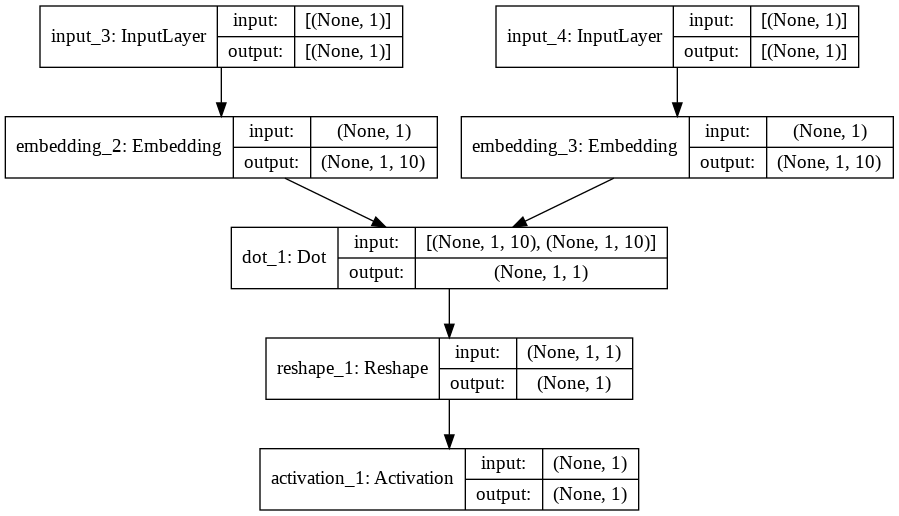

In [ ]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype='int32')
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X,Y)
  print('Epoch :',epoch, 'Loss :',loss)

#### 6) 훈련 결과 확인

In [ ]:
import gensim

In [ ]:
#학습된 임베딩 벡터들을 vector.txt에 저장
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
w2v = KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['archery']) #양궁

In [ ]:
w2v.most_similar(positive=['medal'])